In [11]:
# этот скрипт делает график минутных свечей с индикаторами.

In [12]:
#%pip install numpy
#%pip install pandas
#%pip install mplfinance
#%pip install matplotlib
#%pip install ta
#%pip install pandas_ta

In [13]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
#import ta # https://github.com/bukosabino/ta
import pandas_ta as ta

In [14]:
# параметры:
symbol = 'BTCUSD'
charts_at = '2024-01-01 05:09' # время окончания графика
points = 150 # количество свечей на графике

In [15]:
# DPI в matplotlib = 96 пикселов на дюйм. а размер графика задается в дюймах. поэтому делаю пересчет.
dpi = 96
# магические числа 1.232 и 1.352 подобраны методом тыка, чтобы сохраненный png был ровно 1024x768.
# магические числа 1.285 и 1.352 подобраны методом тыка, чтобы сохраненный png был ровно 1536x768.
width_in_inches = (1024 * 1.232) / dpi
height_in_inches = (768 * 1.352) / dpi

In [16]:
def get_df(date_time, period, length = 1000):
    """
    Загрузить датафрейм с диска и взять с него слайс.
    
    Параметры:
    date_time : string
        Например, 2024-05-29 08:10. Время не обязательно должно попадать в точку графика (будет взята ближайшая точка).
    period : string
        Допустимые значения: '5S' - 5 секунд, '1T' - 1 minute, '5T' - 5 minutes, '1H' - 1 hour, 'D' - 1 day.
    length : number
        Сколько точек надо в датафрейме.
    """
    if period == '5S': # пятисекундные свечи
        # '2024-05-29 08:10' -> '2024-05-29'
        date = date_time[:10]
        filename = f'npz/{symbol}/{symbol}{date}.npz'
    else:
        filename = f'npz/{symbol}_{period}.npz'

    # зачитывание в формате numpy
    data = np.load(filename, allow_pickle=True)['data']
    # преобразование в формат pandas
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Преобразование 'timestamp' в datetime и установка его как индекс DataFrame
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # Преобразование всех столбцов с ценами и объемом в числовой формат
    for column in ['open', 'high', 'low', 'close', 'volume']:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # поиск интересной точки.
    date_to_find = date_to_find = pd.Timestamp(date_time)
    index_position = df.index.get_indexer([date_to_find], method='nearest')[0]
    # беру часть точек, чтобы не напрягать либу технического анализа большим количеством точек.
    df = df[index_position-length:index_position]
    return df

In [17]:
df = get_df(charts_at, '1T')

In [18]:
# стиль графика для mpl. пытаюсь сделать что-то похожее на светлую тему tradingview.
customstyle = mpf.make_mpf_style(base_mpf_style='yahoo', facecolor='w')

In [19]:
#help(ta.vwap)

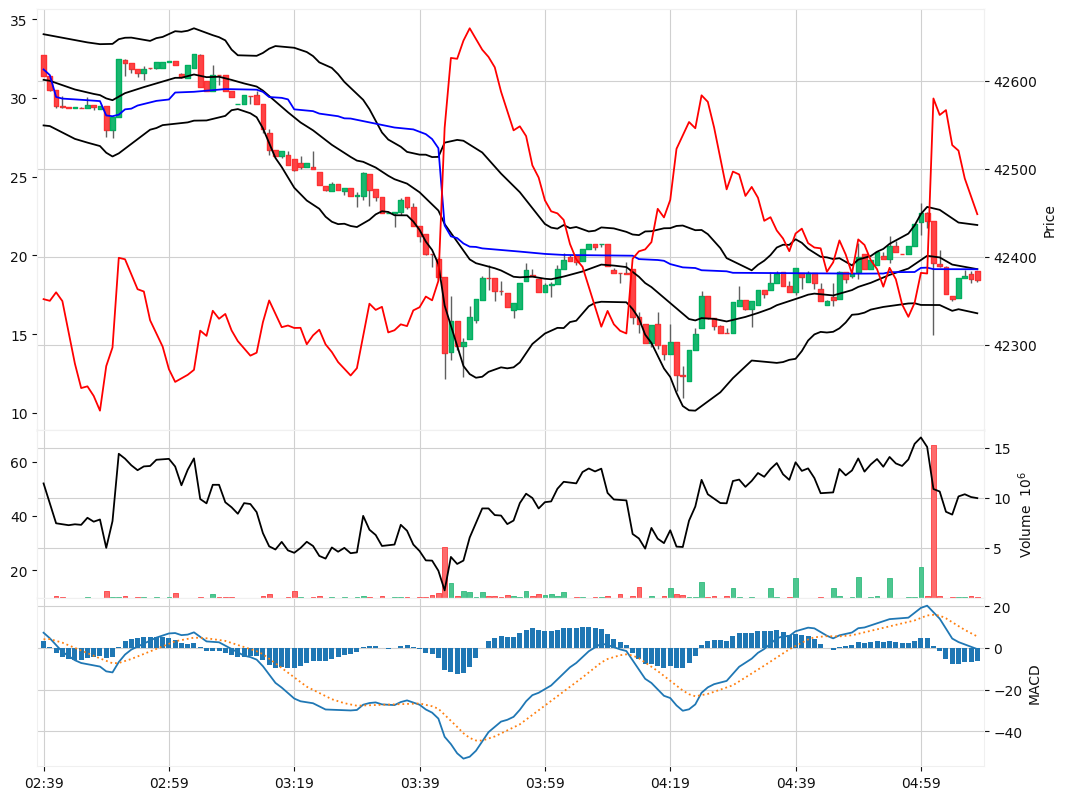

In [20]:
atr = ta.atr(df[-points-10:]['high'],df[-points-10:]['low'],df[-points-10:]['close'], 10)
vwap = ta.vwap(df[-points:]['high'],df[-points:]['low'],df[-points:]['close'],df[-points:]['volume'])
macd = ta.macd(df[-points-200:]['close'], fast=12, slow=26, signal=9, min_periods=None, append=True)
rsi = ta.rsi(df[-points-14:]['close'], 14)

# Bollinger Bands
bb = ta.bbands(df[-points-20:]['close'], length=20, std=2, mamode='ema')
bblow, bbmid, bbup = bb[bb.columns[0]], bb[bb.columns[1]], bb[bb.columns[2]]

# добавление графиков к mpf https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb
apdict = [
    mpf.make_addplot(bbup[-points:], color='black'),
    mpf.make_addplot(bbmid[-points:], color='black'),
    mpf.make_addplot(bblow[-points:], color='black'),
    mpf.make_addplot(atr[-points:], panel=0, color='red'),
    mpf.make_addplot(vwap[-points:], color='blue'),
    mpf.make_addplot(macd[macd.columns[0]][-points:], panel=2, secondary_y=False),
    mpf.make_addplot(macd[macd.columns[2]][-points:], panel=2, linestyle='dotted', ylabel='MACD'),
    mpf.make_addplot(macd[macd.columns[1]][-points:], panel=2, secondary_y=False, type='bar'),
    mpf.make_addplot(rsi[-points:], panel=1, secondary_y=True, color='black'),
    ]

# отрисовка.
fig, ax = mpf.plot(
    df[-points:],
    type='candle',
    volume=True, 
    style=customstyle,
    figsize=(width_in_inches, height_in_inches),
    returnfig=True, # это надо, чтобы mpf.plot вернул fix, ax.
    # разворот подписей по оси X, т.к. в документации openai написано, что повернутый текст он плохо читает (наверное 
    # умышленно порезана модель, чтобы нельзя было ее использовать для распознавания капчи)
    xrotation=0, 
    #return_width_config=wconfig,
    update_width_config={'volume_width': 0.75, 'candle_width': 0.75, 'candle_linewidth': 1},
    addplot=apdict
    )

ax[0].margins(x=0) # убрать отступы слева и справа на графике.
# Сохранение графика с учетом изменений отступов
fig.savefig('img/1T.png', bbox_inches='tight', dpi=dpi)
#fig.imsave(fname='my_image.png', arr=im, cmap='gray_r', format='png')